In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Propagation of elastic waves in a 1D domain

\begin{align}
    \frac{\partial}{\partial x}
    \sigma( x, t ) {\color{red}+f(x,t)}
    & = 
    \rho( x ) \frac{\partial^2}{\partial t^2} 
    u( x, t )
    & \text{for }
    (x, t) \in \Omega \times (0, T)
    \\
    u( x_0, t ) & = U( t ) 
    & \text{for } t \in (0, T)
    \\
    u(x, t), & \, \sigma(x, t)
    &
    \Omega\text{-periodic} \\
    u(x, 0) & = u_0( x )
    & \text{for }
    x \in \Omega \\
    \frac{\partial}{\partial t} u(x, 0) & = v_0( x )
    & \text{for }
    x \in \Omega \\
    \sigma(x, t)
    & = 
    E( x ) \frac{\partial}{\partial x} u(x, t)
    & \text{for }    
    (x, t) \in \Omega \times (0, T)
\end{align}

In [2]:
func_rho = lambda x: 2700. # spatial distribution of density
func_E = lambda x: 70.3e9 # spatial distribution of Young’s modulus
func_u0 = lambda x: 0 * x # inital u_0
func_v0 = lambda x: 0 * x # initial derivation of u, periodical

alpha = 4
A = 0.001
def func_Ut(x0, t, L=2): # The perturbation as a prescribed displacement u(x_0, t) = U(t)
    c0 = np.sqrt(func_E(x0) / func_rho(x0))
    omega = 5 * np.pi * c0 / L
    if  t < np.pi/omega: 
        return A*(t * (np.pi/omega - t))**alpha / ((np.pi/omega)**2 / 4)**alpha
    else:
        return 0.

## Finite element method - direct solver

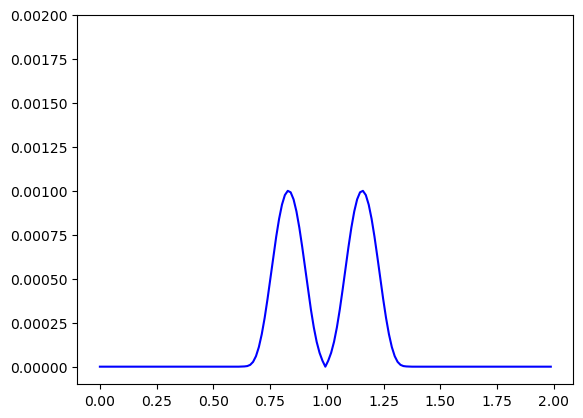

In [3]:
L = 2 # length of the domain in the spatial dimension x
T = 3.9919e-4 # length of the time frame
Nx = 157 # number of intervals in x
Nt = 239 # number of intervals in t
x = np.linspace(0, L, Nx+1)
t = np.linspace(0, T, Nt+1)
dx = L / Nx
dt = T / Nt

con_mat = np.zeros((Nx, 2), dtype=int)
for i in range(Nx): # connectivity matrix
    con_mat[i] = [i, i+1]
    
x = np.linspace(0, L, Nx+1) # nodal coordinates

# Newmark constants for the integration scheme
beta = 0.25 
gamma = 0.5

index_x0 = np.round(Nx/2).astype(int) # placing of the perturbation
x0 = np.zeros(Nx) # displacements on discretized spatial domain at t=0
x0[index_x0] = 1

N = np.array([[1, 0], [0, 1]]) # Shape functions
N_int = np.array([[1/3, 1/6], [1/6, 1/3]])
B = np.array([-1, 1]) # Shape function derivative

M = np.zeros((Nx+1, Nx+1))
K = np.zeros((Nx+1, Nx+1))

for i in range(Nx):
    M[np.ix_(con_mat[i], con_mat[i])] += dx * func_rho(None) * N_int
    K[np.ix_(con_mat[i], con_mat[i])] += func_E(None) * np.outer(B, B) / dx

K[0,:] += K[-1,:]
K[:,0] += K[:,-1]
M[0,:] += M[-1,:]
M[:,0] += M[:,-1]
K_rho = beta * dt**2 * K[:-1,:-1] + M[:-1,:-1]
u0 = func_u0(x[:-1])
dt_u0 =  func_v0(x[:-1])
dtdt_u0 =  K[:-1,:-1] @ u0

g0 = np.linalg.solve(K_rho, x0) # solution at t=0
g0_x0 = g0[index_x0]
t = 0
all_solutions = []
Ft = np.zeros(Nt+1)

for n in range(Nt):
    t += dt
    f = M[:-1,:-1] @ (u0 + dt*dt_u0 + (dt**2)*(0.5 - beta)*dtdt_u0)
    un = np.linalg.solve(K_rho, f)
    Fn = (func_Ut(x0, t) - un[index_x0])/(beta * (dt**2) * g0_x0)
    un += beta * (dt**2)* g0 * Fn
    dtdt_un = 1/(beta * (dt**2)) * (un - u0 - dt*dt_u0 - (dt**2)*(0.5 - beta)*dtdt_u0)
    dt_un = dt_u0 + dt*(1 - gamma)*dtdt_u0 + dt * gamma * dtdt_un
    u0 = un
    dt_u0 = dt_un
    dtdt_u0 = dtdt_un
    Ft[n] = Fn
    all_solutions.append(un)


fig, ax = plt.subplots()
ln, = plt.plot(x[:-1], all_solutions[0], 'b')
ax.set_ylim([-0.0001, 0.002])

def update(frame):
    y = all_solutions[frame]
    ln.set_ydata(y)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(Nt), blit=True)
ani.save('elastodynamics_FE.gif', writer='pillow')

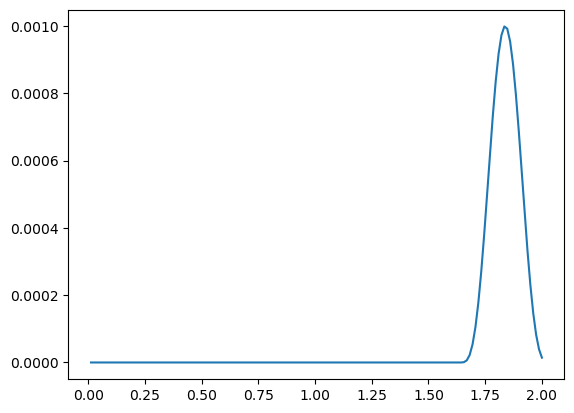

In [4]:
# One wave of the exact solution
c0 = np.sqrt(func_E(None)/func_rho(None)) # wave velocity
omega = 5 * np.pi * c0/L
P = np.zeros(Nx)
dt1 = dx/c0  # time interval for shifting over 1 element
for t1 in np.arange(0, T, dt1):
    P[1:Nx] = P[0:Nx-1]
    if t1 < np.pi/omega: 
        P[0] = A*(t1*(np.pi/omega - t1))**alpha / ((np.pi/omega)**2 / 4)**alpha

plt.plot(x[1:], P)